In [2]:
# Loading pandas
import pandas as pd

# Loading date wrangling package
from datetime import datetime

# Reading the input data
d = pd.read_csv('/Users/anamendoza/Desktop/Cemex Ventures/Energy Project/Time series - Energy Prediction Tutorial/energy consumption dataset/DAYTON_hourly.csv')

# Formating to datetime
d['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in d['Datetime']]

# Making sure there are no duplicated data
# If there are some duplicates we average the data during those duplicated days
d = d.groupby('Datetime', as_index=False)['DAYTON_MW'].mean()

# Sorting the values
d.sort_values('Datetime', inplace=True)

In [3]:
import numpy as np

def create_X_Y(ts: list, lag: int) -> tuple:
    """
    A method to create X and Y matrix from a time series list for the training of 
    deep learning models 
    """
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag):
            Y.append(ts[i + lag])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, Y

In [5]:
# Deep learning packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Defining the number of neurons in the LSTM layer
n_layer = 50

# Defining how many lags will be used in the time series
n_lag = 3

# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))

# The objective functions which will be minimized is mean squared error (mse)
model.compile(optimizer='adam', loss='mse')

/Users/anamendoza/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anamendoza/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anamendoza/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/anamendoza/opt/anaconda3/lib/python3.7/site-pack

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# the whole thing

In [7]:
# Data wrangling
import pandas as pd
import numpy as np

# Deep learning: 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(self, data: pd.DataFrame, Y_var: str, lag: int, LSTM_layer_depth: int, epochs=10, 
                batch_size=256, train_test_split=0):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()   # los datos de DAYTON en lista

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)   # mete a a funcion de createxy la lista de datos DAYTON y el lag para
                                              # guardarlos en X y Y que son el return

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:         # split es porcentaje
            index = round(len(X) * self.train_test_split)  # se calcula el numero de valores que se quieren de test
            X_train = X[:(len(X) - index)]   # del principio de datos hasta antes del valor primer de test
            X_test = X[-index:]     # el numero de test
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model , agrega el diccionario creado arriba para hacer el fit
        model.fit(    # Keras -> fit(x=None, y=None, batch_size=None, epochs=1, shuffle=True, etc)
            **keras_dict    # Using ** to unpack dictionaries into other dictionaries
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

# aplicandolo

In [13]:
# Initiating the class
deep_learner = DeepModelTS(
data = d,
Y_var = 'DAYTON_MW',
lag = 24,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [14]:
# Fitting the model
model = deep_learner.LSTModel()

Train on 103060 samples, validate on 18187 samples
Epoch 1/10
103060/103060 [==============================] - 27s 259us/sample - loss: 586941.8591 - val_loss: 327644.5885
Epoch 2/10
103060/103060 [==============================] - 23s 227us/sample - loss: 141019.8150 - val_loss: 64450.8992
Epoch 3/10
103060/103060 [==============================] - 23s 223us/sample - loss: 88768.5272 - val_loss: 45524.4743
Epoch 4/10
103060/103060 [==============================] - 23s 221us/sample - loss: 99964.8874 - val_loss: 68282.5144
Epoch 5/10
103060/103060 [==============================] - 23s 224us/sample - loss: 44875.2989 - val_loss: 41703.7866
Epoch 6/10
103060/103060 [==============================] - 23s 221us/sample - loss: 39787.4296 - val_loss: 29291.8194
Epoch 7/10
103060/103060 [==============================] - 24s 230us/sample - loss: 54191.0032 - val_loss: 31637.4689
Epoch 8/10
103060/103060 [==============================] - 23s 224us/sample - loss: 40009.6333 - val_loss: 38751

In [15]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = d['DAYTON_MW'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

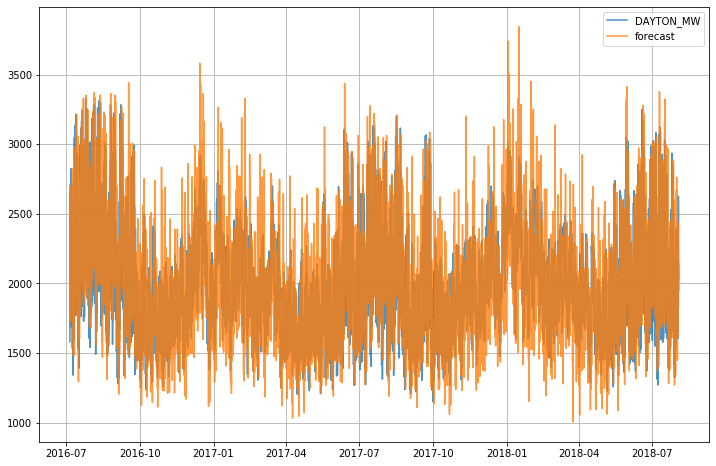

In [16]:
yhat = deep_learner.predict()

# Constructing the forecast dataframe
fc = d.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat

# Ploting the forecasts
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for dtype in ['DAYTON_MW', 'forecast']:
  plt.plot(
    'Datetime',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()
plt.show()

In [18]:
# Creating the model using full data and forecasting n steps 
aheaddeep_learner = DeepModelTS(
data=d,
Y_var='DAYTON_MW',
lag=48,
LSTM_layer_depth=64,
epochs=10,
train_test_split=0
)
# Fitting the model
deep_learner.LSTModel()
# Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

Train on 103060 samples, validate on 18187 samples
Epoch 1/10
103060/103060 [==============================] - 30s 289us/sample - loss: 615619.5165 - val_loss: 44732.1060
Epoch 2/10
103060/103060 [==============================] - 28s 267us/sample - loss: 30746.9695 - val_loss: 15014.8062
Epoch 3/10
103060/103060 [==============================] - 31s 299us/sample - loss: 57155.1462 - val_loss: 57951.3257
Epoch 4/10
103060/103060 [==============================] - 38s 372us/sample - loss: 49237.3463 - val_loss: 37757.2950
Epoch 5/10
103060/103060 [==============================] - 51s 492us/sample - loss: 32238.6728 - val_loss: 22879.4886
Epoch 6/10
103060/103060 [==============================] - 32s 313us/sample - loss: 23871.9848 - val_loss: 17265.5527
Epoch 7/10
103060/103060 [==============================] - 26s 252us/sample - loss: 20667.2459 - val_loss: 15055.9475
Epoch 8/10
103060/103060 [==============================] - 25s 241us/sample - loss: 17910.2589 - val_loss: 12931.0